In [1]:

import os
import sys
import math
import random
import itertools

sys.path.append('../oddsmaker/')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.style.use('ggplot')

from copy import copy
from tqdm import tqdm
from trueskill import TrueSkill, Rating, rate_1vs1



- create normally distributed sample of 10000 players
- select two random ones
- call it "blue player" and "red player"


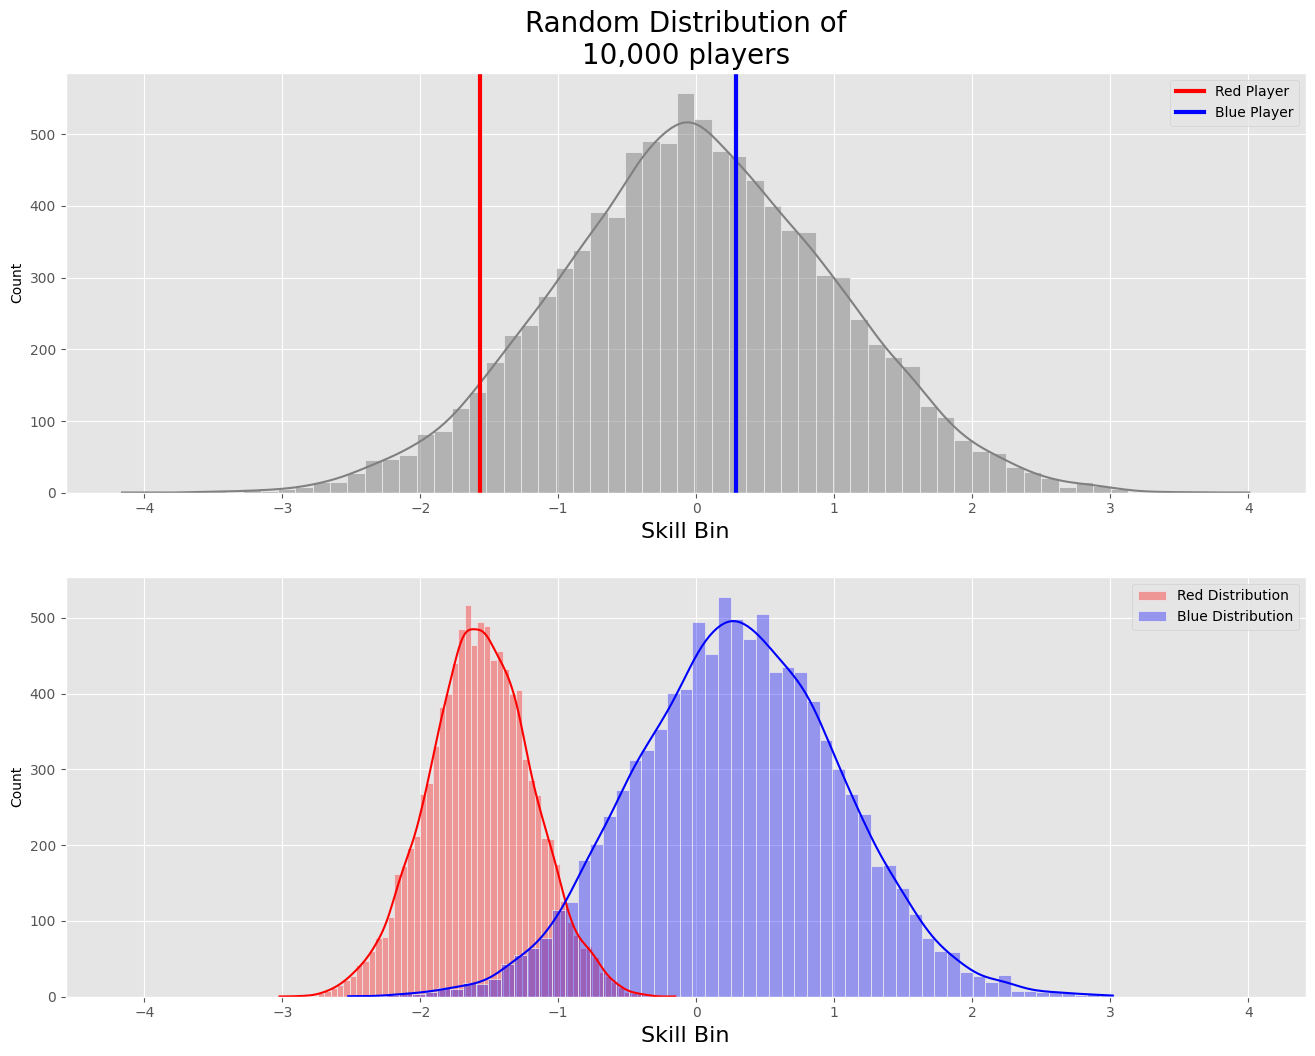

In [2]:


random_distribution = list(np.random.normal(0, 1, 10000))

fig, axes = plt.subplots(2, 1, figsize=(16, 12))
ax1 = axes[0]
ax2 = axes[1]
blue_player = random.sample(random_distribution,1)
red_player = random.sample(random_distribution,1)
red_player=-1.5638447592871616
blue_player=0.2886639240423845
blue_stdev = 0.75
red_stdev = 0.375

ax1.set_title('Random Distribution of\n10,000 players', fontsize=20)
sns.histplot(random_distribution, ax=ax1, color = 'grey', kde=True)
ax1.axvline(red_player, color='red', label='Red Player', lw=3)
ax1.axvline(blue_player, color='blue', label='Blue Player', lw=3)
ax1.set_xlabel('Skill Bin',fontsize=16)
ax1.legend()

blue_player_dist = np.random.normal(blue_player, blue_stdev, 10000)
red_player_dist = np.random.normal(red_player, red_stdev, 10000)
sns.histplot(red_player_dist, ax=ax2, color = 'red', alpha=0.35, kde=True, label='Red Distribution')
sns.histplot(blue_player_dist, ax=ax2, color = 'blue', alpha=0.35, kde=True, label='Blue Distribution')

ax2.set_xlabel('Skill Bin',fontsize=16)
ax2.set_xlim(ax1.get_xlim())

ax2.legend()
plt.savefig('C://Users/Blake/Downloads/medium_uncertain_1.png')
plt.show()


In [3]:

print(red_player, blue_player, red_stdev, blue_stdev)


-1.5638447592871616 0.2886639240423845 0.375 0.75



- coming up with distribution of their skill differences


In [4]:

mean_z = blue_player-red_player
stdev_z = np.sqrt(red_stdev**2+blue_stdev**2)

def sigmoid(x):
    return 1/(1+np.exp(-x))


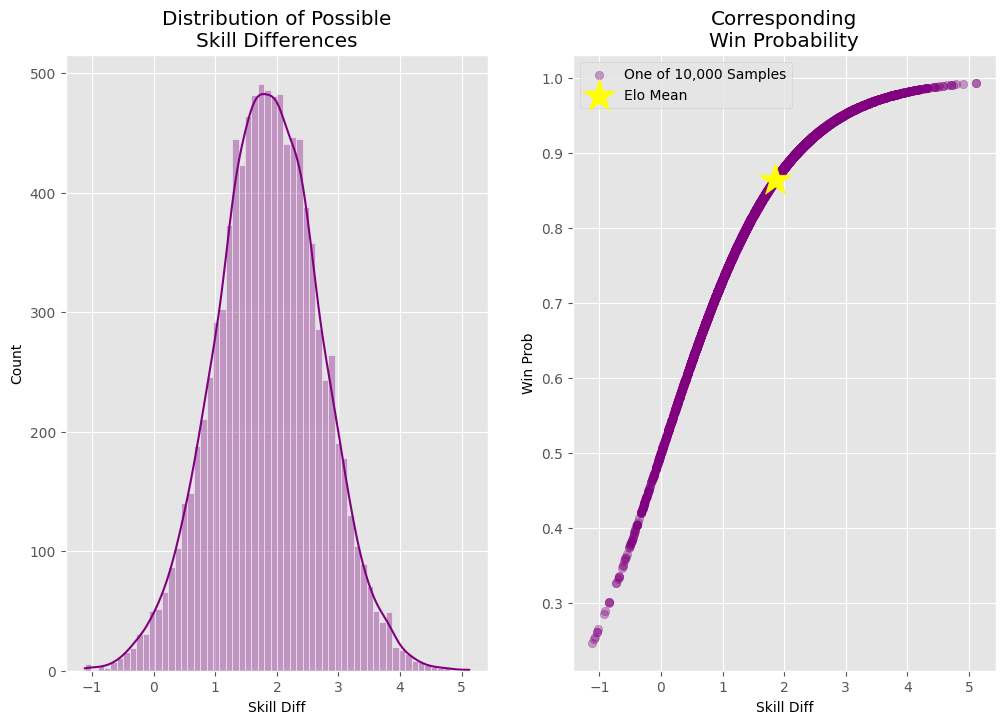

In [6]:

fig, axes = plt.subplots(1,2, figsize=(12,8))
left_ax = axes[0]
right_ax = axes[1]
z_dist = np.random.normal(mean_z, stdev_z, 10000)
probs_z = sigmoid(z_dist)
left_ax.set_title('Distribution of Possible\nSkill Differences')
left_ax.set_xlabel('Skill Diff')
right_ax.set_title('Corresponding\nWin Probability')
right_ax.set_xlabel('Skill Diff')
right_ax.set_ylabel('Win Prob')
sns.histplot(z_dist, ax=left_ax, color = 'purple', alpha=0.35, kde=True, label='Purple Distribution')
right_ax.scatter(z_dist, probs_z, color='purple', alpha=0.35, label='One of 10,000 Samples')
right_ax.scatter(np.array(mean_z), sigmoid(np.array(mean_z)), color='yellow', marker='*', s=600, label='Elo Mean')
right_ax.legend()
right_ax.set_xlim(left_ax.get_xlim())
plt.savefig('C://Users/Blake/Downloads/medium_uncertain_3.png')
plt.show()


In [183]:

### generate data ###
ratings = {
    'A':1900,
    'B':1700,
    'C':1500,
    'D':1300,
    'E':1100
}

prob_table = []
for player_1, rating_1 in ratings.items():
    for player_2, rating_2 in ratings.items():
        if player_1 == player_2:
            prob_table.append([player_1, player_2, np.nan])
            continue
        rd = rating_2-rating_1
        prob = 1/(1+10**(rd/400))
        prob_table.append([player_1, player_2, prob])
        
prob_table = pd.DataFrame(prob_table, columns=['player_1','player_2','prob'])


test = prob_table.pivot(index='player_1', columns=['player_2'], values='prob')
test


player_2,A,B,C,D,E
player_1,,,,,
A,NaN,0.759747,0.909091,0.969347,0.990099
B,0.240253,NaN,0.759747,0.909091,0.969347
C,0.090909,0.240253,NaN,0.759747,0.909091
D,0.030653,0.090909,0.240253,NaN,0.759747
E,0.009901,0.030653,0.090909,0.240253,NaN



### Methodology comparison of different ways to incorporate uncertainty


In [90]:

from copy import deepcopy

MU = 1500
RD = 350
MAX_RD = 350

## time between games
## going small, don't want it to affect
C = 1

class GlickoRating():
    
    def __init__(self,mu=MU, rd=RD, max_RD = MAX_RD):
        
        self.mu=mu
        self.rd=rd
        self.max_rd=max_RD
        self.games_played = 0
        
        return
    
    def prep(self,time_off=1):
        
        ## update RD for time off
        self.rd =np.min([np.sqrt(self.rd**2+time_off**2),self.max_rd])
        
        return
    
    
class GlickoMatch():
    
    """
    Input two glicko objects. Returns modified objects based on result.
    Result can be randomly generated or provided
    
    """
    
    def __init__(self, player_a, player_a_time_off, player_b, player_b_time_off, 
                 q=np.log(10)/400
                ):
        
        self.player_a = deepcopy(player_a)
        self.a_time_off = player_a_time_off
        self.player_b = deepcopy(player_b)
        self.b_time_off = player_b_time_off
        
        self.q = q
        return
    
    def play_single_match(self, result):
        
        
        
        self.player_a.prep(self.a_time_off)
        self.player_b.prep(self.b_time_off)
        
        self.g_opp = 1/np.sqrt((1+(3*self.q**2)*(self.player_b.rd**2)/np.pi**2))
        
        exp_res = 1/(1+10**((-self.g_opp*(self.player_a.mu-self.player_b.mu))/400))
        d_sq = 1/(self.q**2 * self.g_opp**2*(exp_res)*(1-exp_res))
        
        
        self.player_a.mu = self.player_a.mu + (self.q/(1/self.player_a.rd**2+1/d_sq)*self.g_opp*(result-exp_res))
        self.player_a.rd = np.sqrt(1/(1/self.player_a.rd**2 + 1/d_sq))
        self.player_a.games_played+=1
        
        return self.player_a
    
    
class GlickoMatches():
    
    """
    Input two glicko objects. Returns modified objects based on result.
    Result can be randomly generated or provided
    
    """
    
    def __init__(self, player_a, player_a_time_off, opponents, opp_times_off, 
                 q=np.log(10)/400
                ):
        
        self.player_a = deepcopy(player_a)
        self.a_time_off = player_a_time_off
        assert(type(opponents)==list)
        assert(type(opp_times_off)==list)
        assert(len(opponents)==len(opp_times_off))
        self.opponents = deepcopy(opponents)
        self.num_opps = len(self.opponents)
        self.opp_times_off = opp_times_off
        
        
        self.q = q
        return
    
    def play_rating_period(self, results):
        
        assert(type(results)==list)

        self.player_a.prep(self.a_time_off)

        for i, opp in enumerate(self.opponents):
            opp.prep(self.opp_times_off[i])
        
        g_opps = []
        for opp in self.opponents:
            g_opp = 1/np.sqrt((1+(3*self.q**2)*(opp.rd**2)/np.pi**2))
            g_opps.append(g_opp)
            
        print(g_opps)
        exp_results = []
        for i, opp in enumerate(self.opponents):
            exp_res = 1/(1+10**((-g_opps[i]*(self.player_a.mu-opp.mu))/400))
            exp_results.append(exp_res)
            
        print(exp_results)
        d_sq = 1/(self.q**2 * np.sum([g_opps[i]**2*(exp_results[i])*(1-exp_results[i]) for i in range(self.num_opps)]))
        print(d_sq)
        
        self.player_a.mu = self.player_a.mu + (self.q/(1/self.player_a.rd**2+1/d_sq)*np.sum([g_opps[i]*(results[i]-exp_results[i]) for i in range(self.num_opps)]))
        self.player_a.rd = np.sqrt(1/(1/self.player_a.rd**2 + 1/d_sq))
        
        
        print(self.player_a.mu, self.player_a.rd)
        return self.player_a


    


In [91]:

### test to verify matches paper
p1 = GlickoRating(1500, 200)
p2 = GlickoRating(1400, 30)
p3 = GlickoRating(1550, 100)
p4 = GlickoRating(1700, 300)

matches = GlickoMatches(p1, 0, [p2,p3,p4], [0,0,0])

matches.play_rating_period([1,0,0])


[0.9954980060779481, 0.953148974234587, 0.7242354637384434]
[0.639467736007921, 0.43184235355955686, 0.30284072524764]
53685.74290197874
1464.1064627569112 151.39890244796933


In [92]:

p1 = GlickoRating(1500, 200)
p2 = GlickoRating(1400, 30)
p3 = GlickoRating(1550, 100)
p4 = GlickoRating(1700, 300)

match = GlickoMatch(p1, 0, p2, 0)
p1 = match.play_single_match(1)

match = GlickoMatch(p1, 0, p3, 0)
p1 = match.play_single_match(0)

match = GlickoMatch(p1, 0, p4, 0)
p1 = match.play_single_match(0)



In [159]:

class EloRating():
    def __init__(self, mu=1500):
        self.mu = mu
        self.games_played = 0

class EloMatch():
    def __init__(self, p1, p2, k=12):
        self.p1 = p1
        self.p2 = p2
        self.k = k
        
    def play_single_match(self, result):
        
        exp = 1/(1+10**((self.p2.mu-self.p1.mu)/400))
        mod = self.k*(result-exp)
        self.p1.mu +=mod
        self.p1.games_played+=1
        return self.p1
    
        
### Basic Elo Test ###
num_tests = 10000
num_games_per_test = 200
elo_test_data = []
k = 24
for test in tqdm(range(num_tests)):
    true_ratings = {
        'A':1900,
        'B':1700,
        'C':1500,
        'D':1300,
        'E':1100
    }
    players = {
        'A':EloRating(),
        'B':EloRating(),
        'C':EloRating(),
        'D':EloRating(),
        'E':EloRating()
    }
    player_list = list(players.keys())
    for game in range(num_games_per_test):
        ## randomly choose two players
        p1,p2 = random.sample(player_list, 2)
        p1_obj = players[p1]
        p2_obj = players[p2] 
        match_1 = EloMatch(p1_obj, p2_obj,k=k) 
        match_2 = EloMatch(p2_obj, p1_obj,k=k)
        
        p1_true = true_ratings[p1]
        p2_true = true_ratings[p2]
        
        prob = 1/(1+10**((p2_true-p1_true)/400))
        if np.random.random() < prob:
            result = 1
        else:
            result = 0
            
        p1_obj = players[p1]
        p2_obj = players[p2]
        
        elo_test_data.append([test+1, p1, p1_obj.games_played, p1_obj.mu])
        elo_test_data.append([test+1, p2, p2_obj.games_played, p2_obj.mu])
        
        p1_obj = match_1.play_single_match(result)
        p2_obj = match_2.play_single_match(1-result)
        
        players[p1] = p1_obj
        players[p2] = p2_obj
        
elo_test_data = pd.DataFrame(elo_test_data, columns=['test_num','player','games_played','rating'])
        
        

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:19<00:00, 518.27it/s]


In [160]:


elo_test = elo_test_data.groupby(['player','games_played']).agg({
    'rating':['mean','count'],
}).copy().reset_index()

elo_test.columns=['player','games_played','rating_mean','sample']
elo_test = elo_test.loc[elo_test['sample']>150].reset_index(drop=True)
elo_test


,player,games_played,rating_mean,sample
0,A,0,1500.000000,10000
1,A,1,1509.494882,10000
2,A,2,1518.729904,10000
3,A,3,1527.583640,10000
4,A,4,1536.019264,10000
...,...,...,...,...
470,E,90,1210.465341,639
471,E,91,1209.773844,500
472,E,92,1208.666530,377
473,E,93,1207.256172,258


In [105]:


### Glicko Test ###
num_tests = 10000
num_games_per_test = 200


def initialize_players():
    glicko_players = {
        'A':GlickoRating(),
        'B':GlickoRating(),
        'C':GlickoRating(),
        'D':GlickoRating(),
        'E':GlickoRating()
    }
    
    ratings_map = {
        'A':1900,
        'B':1700,
        'C':1500,
        'D':1300,
        'E':1100
    }
    
    return glicko_players, ratings_map

### test convergence ###
test_data = []
for test in tqdm(range(num_tests)):
    players, true_ratings = initialize_players()
    player_list = list(players.keys())
    for game in range(num_games_per_test):
        
        ## randomly choose two players
        p1,p2 = random.sample(player_list, 2)
        p1_obj = players[p1]
        p2_obj = players[p2] 
        
        match_1 = GlickoMatch(p1_obj, 0, p2_obj, 0)
        match_2 = GlickoMatch(p2_obj, 0, p1_obj, 0)
        
        p1_true = true_ratings[p1]
        p2_true = true_ratings[p2]
        
        prob = 1/(1+10**((p2_true-p1_true)/400))
        if np.random.random() < prob:
            result = 1
        else:
            result = 0
            
        test_data.append([test+1, p1, p1_obj.games_played, p1_obj.mu, p1_obj.rd])
        test_data.append([test+1, p2, p2_obj.games_played, p2_obj.mu, p2_obj.rd])
            
        p1_obj = match_1.play_single_match(result)
        p2_obj = match_2.play_single_match(1-result)
        
        players[p1] = p1_obj
        players[p2] = p2_obj
        
test_data = pd.DataFrame(test_data, columns=['test_num','player','games_played','rating','rd'])


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [04:11<00:00, 39.80it/s]


In [114]:

glicko_test = test_data.groupby(['player','games_played']).agg({
    'rating':['mean','count'],
    'rd':'mean'
}).copy().reset_index()
glicko_test.columns=['player','games_played','rating_mean','sample','rd_mean']
glicko_test = glicko_test.loc[glicko_test['sample']>150].reset_index(drop=True)



In [234]:



### TrueSkill test
num_tests = 10000
num_games_per_test = 200

MU = 1500
SIGMA = 350
BETA = SIGMA / 1.9
TAU = SIGMA / 1000
DRAW_PROBABILITY = 0

env = TrueSkill(mu=MU, sigma=SIGMA, beta=BETA, tau=TAU, draw_probability=DRAW_PROBABILITY)
env.make_as_global() 

def win_probability(team1, team2):
    delta_mu = sum(r.mu for r in team1) - sum(r.mu for r in team2)
    sum_sigma = sum(r.sigma ** 2 for r in itertools.chain(team1, team2))
    size = len(team1) + len(team2)
    denom = math.sqrt(size * (BETA * BETA) + sum_sigma)
    ts = trueskill.global_env()
    return ts.cdf(delta_mu / denom)


def initialize_players():
    TS_players = {
        'A':env.create_rating(),
        'B':env.create_rating(),
        'C':env.create_rating(),
        'D':env.create_rating(),
        'E':env.create_rating()
    }
    
    ratings_map = {
        'A':1900,
        'B':1700,
        'C':1500,
        'D':1300,
        'E':1100
    }
    
    return TS_players, ratings_map

### test convergence ###
TS_test_data = []
for test in tqdm(range(num_tests)):
    players, true_ratings = initialize_players()
    player_list = list(players.keys())
    
    gp_count = {
        'A':0,
        'B':0,
        'C':0,
        'D':0,
        'E':0
    }
    
    for game in range(num_games_per_test):
        
        ## randomly choose two players
        p1,p2 = random.sample(player_list, 2)
        p1_obj = players[p1]
        p2_obj = players[p2] 
        
        p1_true = true_ratings[p1]
        p2_true = true_ratings[p2]
        
        TS_test_data.append([test+1, p1, gp_count[p1], p1_obj.mu, p1_obj.sigma])
        TS_test_data.append([test+1, p2, gp_count[p2], p2_obj.mu, p2_obj.sigma])
        
        gp_count[p1] +=1
        gp_count[p2] +=1
        
        prob = 1/(1+10**((p2_true-p1_true)/400))
        if np.random.random() < prob:
            new_p1, new_p2 = rate_1vs1(p1_obj, p2_obj)
        else:
            new_p2, new_p1 = rate_1vs1(p2_obj, p1_obj)
        
        players[p1] = new_p1
        players[p2] = new_p2
        
TS_test_data = pd.DataFrame(TS_test_data, columns=['test_num','player','games_played','rating','rd'])

    


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [07:01<00:00, 23.72it/s]


In [235]:
TS_test = TS_test_data.groupby(['player','games_played']).agg({
    'rating':['mean','count'],
    'rd':'mean'
}).copy().reset_index()
TS_test.columns=['player','games_played','rating_mean','sample','rd_mean']
TS_test = TS_test.loc[TS_test['sample']>150].reset_index(drop=True)


In [322]:

class AtkinsonRtg():
    def __init__(self, mu=0, sigma=2):
        self.mu = mu
        self.sigma = sigma
        self.games_played = 0
    
class AtkinsonMatch():
    def __init__(self, p1, p2, k=1):
        
        self.p1 = copy(p1)
        self.p2 = copy(p2)
        self.k = k
        
    def play_h2h(self, result):
        
        z = self.p1.mu - self.p2.mu
        z_var = self.p1.sigma**2+self.p2.sigma**2
#         print(z, z_var)
        beta_ev = 1/(1+np.exp(-z))
        beta_sample_size = 1/((beta_ev-beta_ev**2)*z_var**2)
        
        alpha = beta_sample_size*beta_ev
        beta = beta_sample_size - alpha
        
        # Calculate the posterior alpha and beta parameters
        alpha_posterior = alpha + (result)*self.k
        beta_posterior = beta + (1 - result)*self.k
        
        new_ev = alpha_posterior/(alpha_posterior+beta_posterior)
        new_sample = (alpha_posterior+beta_posterior)
        
        new_z = -np.log((1/new_ev)-1)
        new_z_var = np.sqrt(1/((new_ev-new_ev**2)*new_sample))
        
#         print(new_z, new_z_var)
        
        z_diff = new_z-z
        a_move = z_diff*((self.p1.sigma**2)/z_var)
        b_move = -z_diff*((self.p2.sigma**2)/z_var)
        
        a_var_change = (self.p1.sigma**2/z_var)*(z_var-new_z_var)
        b_var_change = (self.p2.sigma**2/z_var)*(z_var-new_z_var)
        
        self.p1.mu+=a_move
        self.p2.mu+=b_move
        
        self.p1.sigma = np.sqrt(self.p1.sigma**2-a_var_change)
        self.p2.sigma = np.sqrt(self.p2.sigma**2-b_var_change)
        
        self.p1.games_played+=1
        self.p2.games_played+=1
        
        return self.p1, self.p2
    
player_1 = AtkinsonRtg(0.2, 2)
player_2 = AtkinsonRtg(-0.2, 2)

match = AtkinsonMatch(player_1, player_2)
new_p1, new_p2 = match.play_h2h(0)
new_p1, new_p2 = match.play_h2h(1)
# print(player_1.mu, player_1.sigma)
# print(new_p1.mu, new_p2.sigma)



In [323]:

### Atkinson Test ###
num_tests = 10000
num_games_per_test = 200


def initialize_players():
    atk_players = {
        'A':AtkinsonRtg(),
        'B':AtkinsonRtg(),
        'C':AtkinsonRtg(),
        'D':AtkinsonRtg(),
        'E':AtkinsonRtg()
    }
    
    ratings_map = {
        'A':2.302586192994541,
        'B':1.1512929483566257,
        'C':0,
        'D':-1.1512929483566257,
        'E':-2.302586192994541
    }
    
    return atk_players, ratings_map

### test convergence ###
atk_test_data = []
for test in tqdm(range(num_tests)):
    players, true_ratings = initialize_players()
    player_list = list(players.keys())
    for game in range(num_games_per_test):
        
        ## randomly choose two players
        p1,p2 = random.sample(player_list, 2)
        p1_obj = players[p1]
        p2_obj = players[p2] 
        
        match = AtkinsonMatch(p1_obj, p2_obj)
        
        p1_true = true_ratings[p1]
        p2_true = true_ratings[p2]
        
        z = p1_true-p2_true
        prob = 1/(1+np.exp(-z))
        if np.random.random() < prob:
            result = 1
        else:
            result = 0
            
        atk_test_data.append([test+1, p1, p1_obj.games_played, p1_obj.mu, p1_obj.sigma])
        atk_test_data.append([test+1, p2, p2_obj.games_played, p2_obj.mu, p2_obj.sigma])
            
        p1_obj, p2_obj = match.play_h2h(result)
        
        players[p1] = p1_obj
        players[p2] = p2_obj
        
atk_test_data = pd.DataFrame(atk_test_data, columns=['test_num','player','games_played','rating','rd'])


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:55<00:00, 178.69it/s]


In [324]:

atk_test = atk_test_data.groupby(['player','games_played']).agg({
    'rating':['mean','count'],
    'rd':'mean'
}).copy().reset_index()
atk_test.columns=['player','games_played','rating_mean','sample','rd_mean']
atk_test = atk_test.loc[atk_test['sample']>150].reset_index(drop=True)


In [301]:

# player_2	A	B	C	D	E
# player_1					
# A	NaN	0.759747	0.909091	0.969347	0.990099
# B	0.240253	NaN	0.759747	0.909091	0.969347
# C	0.090909	0.240253	NaN	0.759747	0.909091
# D	0.030653	0.090909	0.240253	NaN	0.759747
# E	0.009901	0.030653	0.090909	0.240253	NaN

In [1]:
atk_a_plot = atk_test.loc[atk_test['player']=="A"].copy()

NameError: name 'atk_test' is not defined

In [236]:
TS_a_plot = TS_test.loc[TS_test['player']=="A"].copy()

In [230]:
glicko_a_plot = glicko_test.loc[glicko_test['player']=="A"].copy()

In [231]:
elo_a_plot = elo_test.loc[elo_test['player']=='A'].copy()


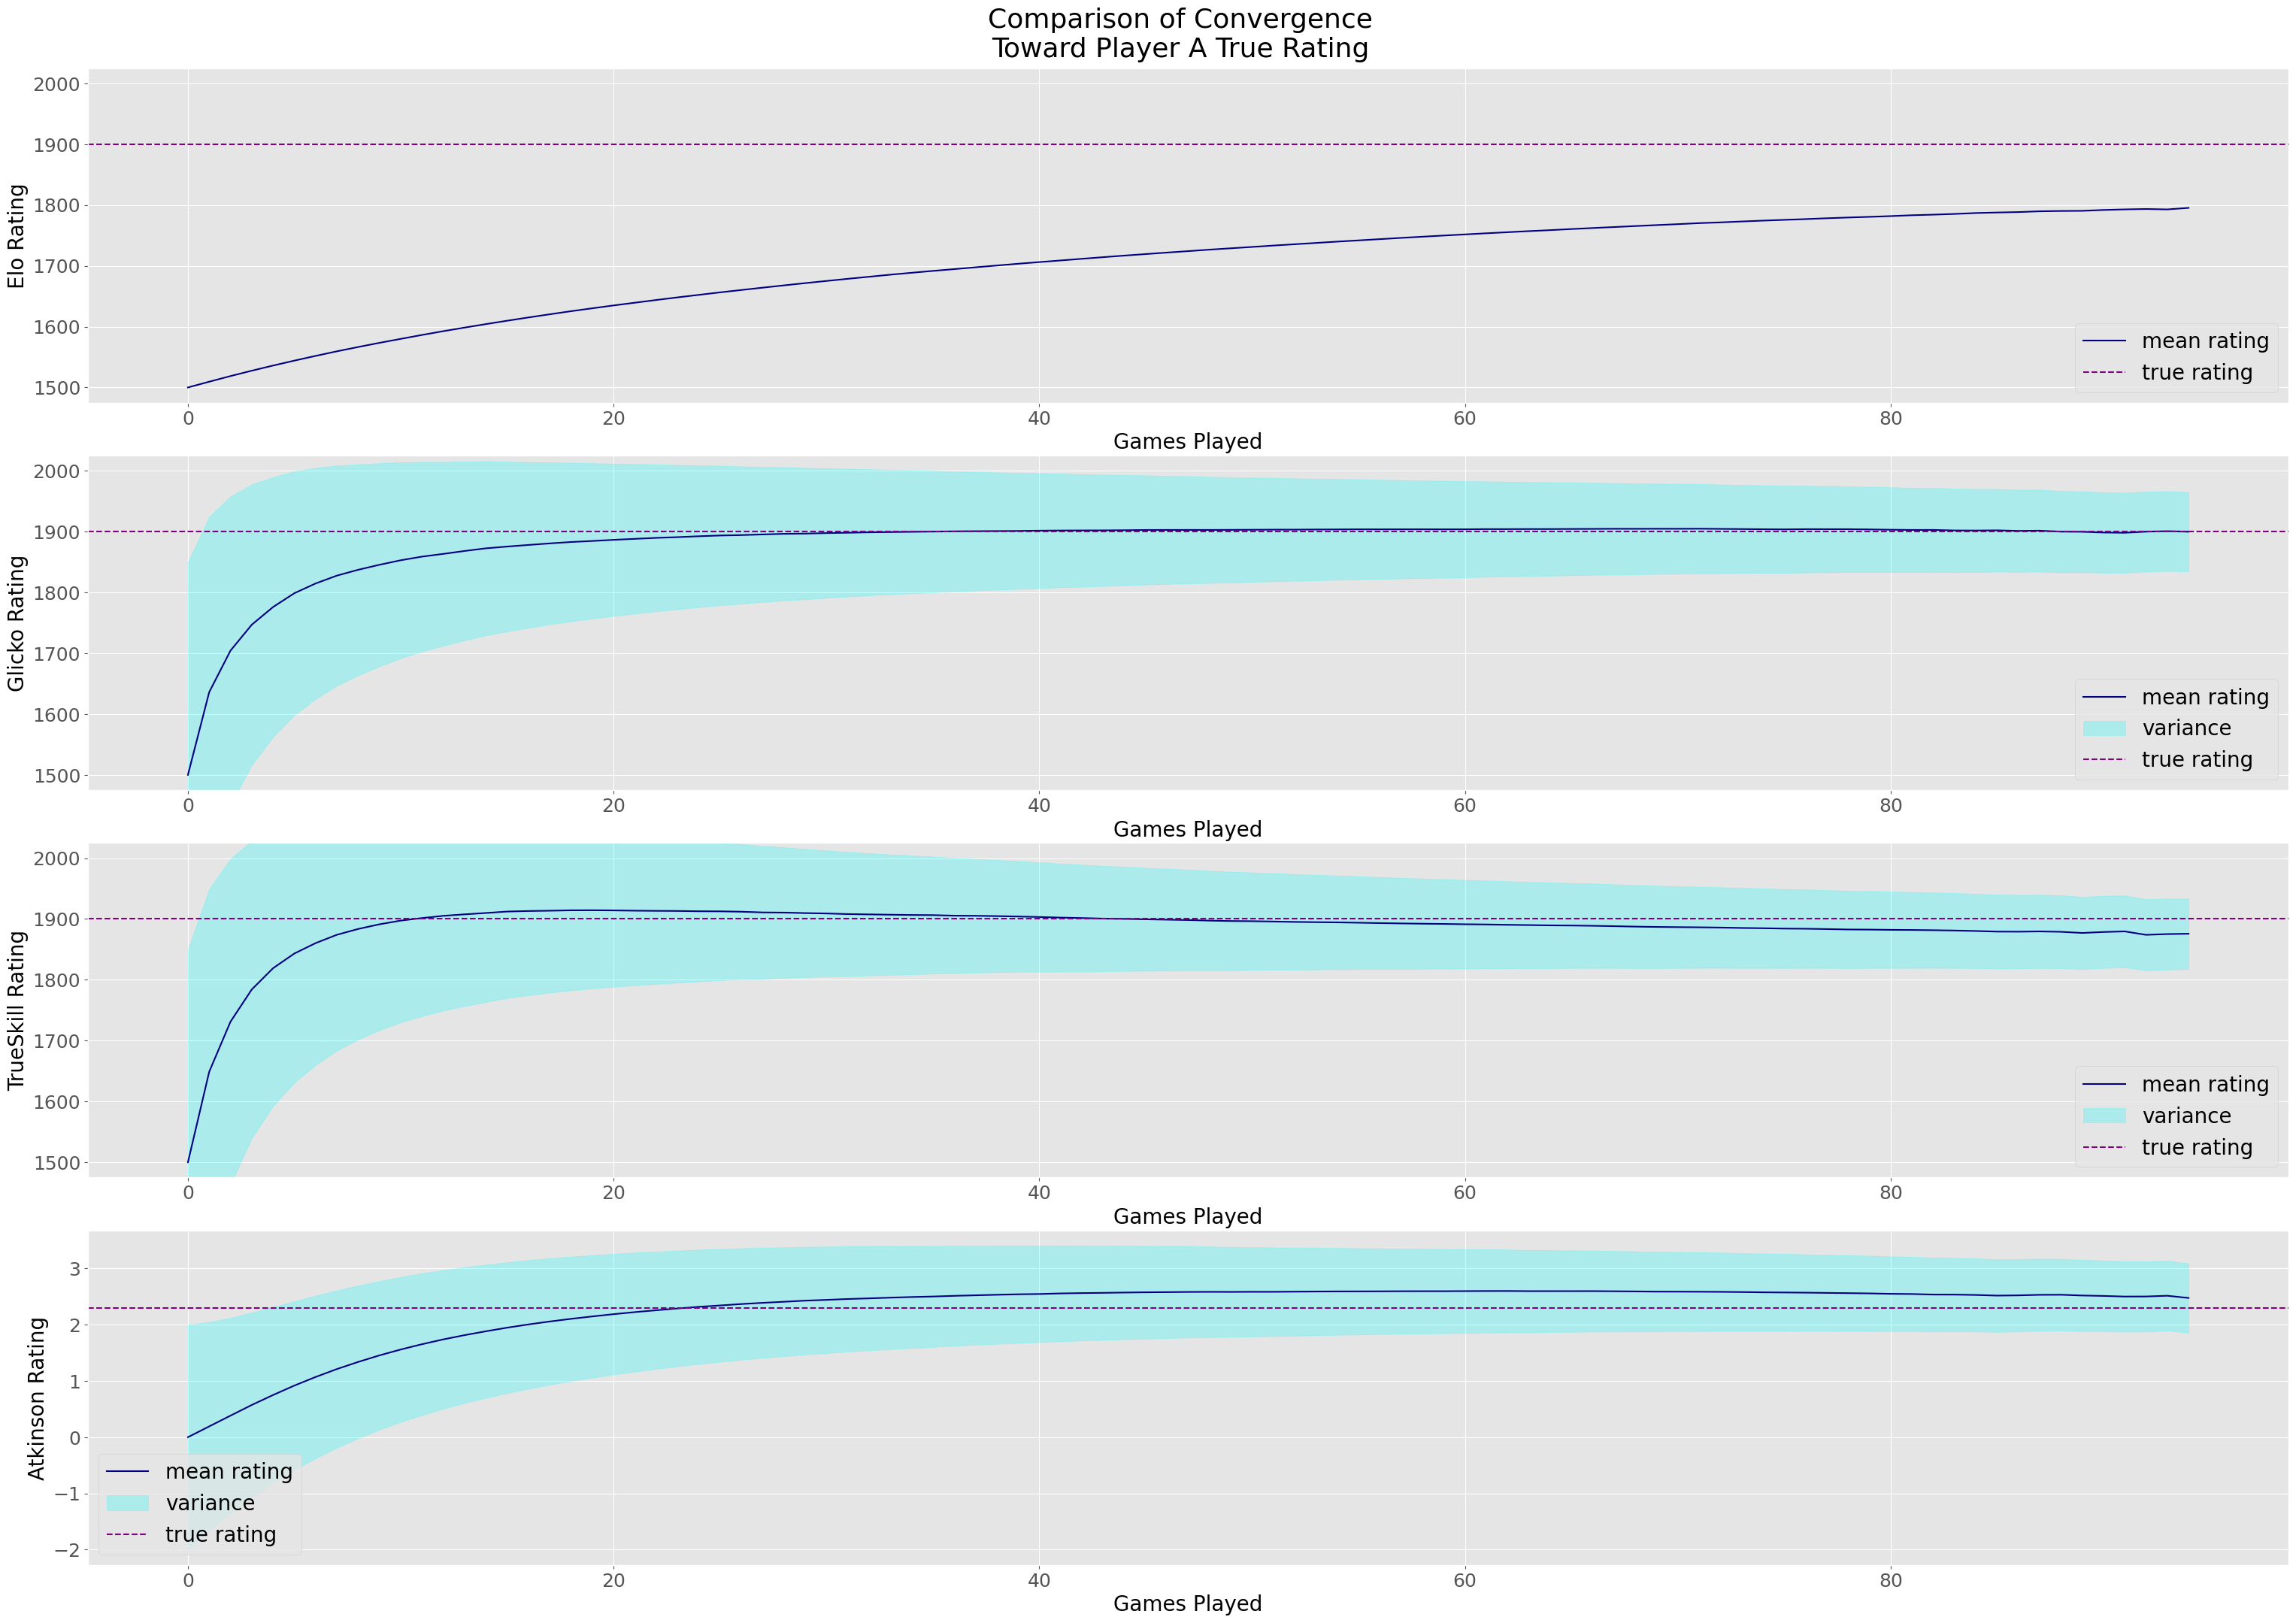

In [327]:

fig, axes = plt.subplots(4, 1, figsize=(30, 14))

plt.suptitle("Comparison of Convergence\nToward Player A True Rating", fontsize=26)
plt.tight_layout()
plt.subplots_adjust(
    bottom=-0.5
)
ax1 = axes[0]
ax2 = axes[1]
ax3 = axes[2]
ax4 = axes[3]

ax1.plot(elo_a_plot.games_played, elo_a_plot.rating_mean, c='navy', label='mean rating')
ax1.set_xlabel('Games Played', fontsize=20)
ax1.set_ylabel('Elo Rating', fontsize=20)
ax1.axhline(2000, color='green', alpha = 0, linestyle='--')
ax1.axhline(1900, color='purple', linestyle='--', label='true rating')
ax1.legend(fontsize=20)
ax1.tick_params(axis='both', which='major', labelsize=18)

ax2.plot(glicko_a_plot.games_played, glicko_a_plot.rating_mean, c='navy', label='mean rating')
ax2.fill_between(glicko_a_plot.games_played, glicko_a_plot.rating_mean-glicko_a_plot.rd_mean, glicko_a_plot.rating_mean+glicko_a_plot.rd_mean,alpha=0.25, label='variance', color='cyan')
ax2.set_xlabel('Games Played', fontsize=20)
ax2.set_ylabel('Glicko Rating', fontsize=20)
ax2.set_xlim(ax1.get_xlim())
ax2.set_ylim(ax1.get_ylim())
ax2.axhline(1900, color='purple', linestyle='--', label='true rating')
ax2.legend(fontsize=20)
ax2.tick_params(axis='both', which='major', labelsize=18)

ax3.plot(TS_a_plot.games_played, TS_a_plot.rating_mean, c='navy', label='mean rating')
ax3.fill_between(TS_a_plot.games_played, TS_a_plot.rating_mean-TS_a_plot.rd_mean, TS_a_plot.rating_mean+TS_a_plot.rd_mean,alpha=0.25, label='variance', color='cyan')
ax3.set_xlabel('Games Played', fontsize=20)
ax3.set_ylabel('TrueSkill Rating', fontsize=20)
ax3.set_xlim(ax1.get_xlim())
ax3.set_ylim(ax1.get_ylim())
ax3.axhline(1900, color='purple', linestyle='--', label='true rating')
ax3.legend(fontsize=20)
ax3.tick_params(axis='both', which='major', labelsize=18)

ax4.plot(atk_a_plot.games_played, atk_a_plot.rating_mean, c='navy', label='mean rating')
ax4.fill_between(atk_a_plot.games_played, atk_a_plot.rating_mean-atk_a_plot.rd_mean, atk_a_plot.rating_mean+atk_a_plot.rd_mean,alpha=0.25, label='variance', color='cyan')
ax4.set_xlabel('Games Played', fontsize=20)
ax4.set_ylabel('Atkinson Rating', fontsize=20)
# ax4.set_xlim(ax1.get_xlim())
# ax4.set_ylim(ax1.get_ylim())
ax4.axhline(2.75, color='green', alpha = 0, linestyle='--')
ax4.axhline(2.302586192994541, color='purple', linestyle='--', label='true rating')
ax4.legend(fontsize=20)
ax4.tick_params(axis='both', which='major', labelsize=18)
plt.show()


In [290]:

TS_test.loc[TS_test.games_played==15]


,player,games_played,rating_mean,sample,rd_mean
15,A,15,1912.208858,10000,142.244525
110,B,15,1705.569391,10000,127.142898
206,C,15,1501.190263,10000,122.015165
301,D,15,1293.883772,10000,127.176661
396,E,15,1088.460142,10000,142.333878


In [ ]:

TS_test.loc[TS_test.games_played==90]



<Axes: ylabel='Count'>

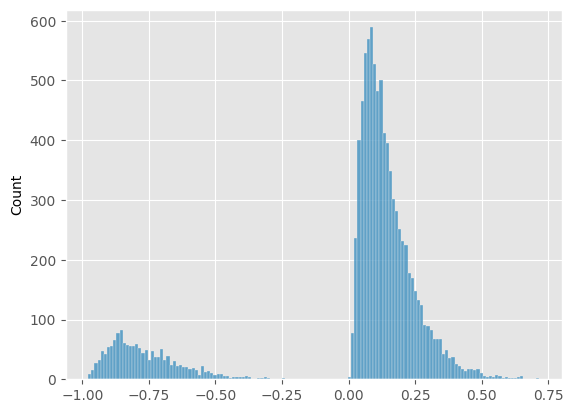

In [109]:

sns.histplot(mod_z)


In [71]:
from scipy.stats import skew, kurtosis

skew(b1)

0.5157879752344258

In [73]:

kurtosis(b1)


0.62823303703605

In [74]:

skew(blue_player_dist)


0.01680060338958342

In [75]:
kurtosis(blue_player_dist)

0.05088508389107815

In [82]:
b1


array([1.35175245, 1.72728122, 0.70590845, ..., 0.69519174, 1.44002127,
       1.42901621])

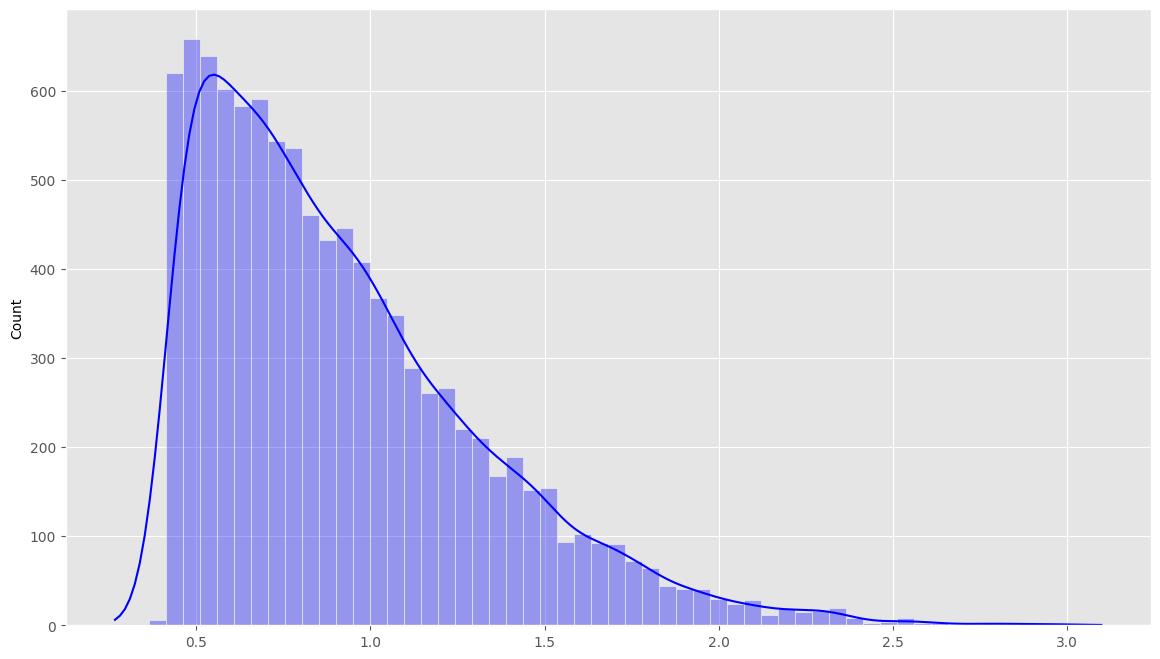

In [84]:

fig, ax = plt.subplots(figsize=(14, 8))

sns.histplot(b1, ax=ax, color = 'blue', alpha=0.35, kde=True, label='Red Distribution')
# sns.histplot(r1, color = 'red', alpha=0.35, kde=True, label='Orange Distribution')
# sns.histplot(new_z, color = 'yellow', alpha=0.35, kde=True, label='Yellow Distribution')
# sns.histplot(z_w3, color = 'brown', alpha=0.35, kde=True, label='Brown Distribution')

plt.show()
